In [1]:
pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 29.6 MB/s eta 0:00:00


In [2]:
import math, time, re
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from dtaidistance import dtw
import matplotlib.pyplot as plt

In [3]:
BASE_DIR=Path("/content/drive/MyDrive/Dance_clean_data")

In [4]:
SEQ_IN,SEQ_OUT=30,30
BATCH=128
EPOCHS=10
HIDDEN=128
LAYERS=2
LR=3e-4
WDECAY=1e-4
D_MODEL=128
NHEAD=8
N_ENC=2
N_DEC=2
DROPOUT=0.1
VEL_W=0.1
GRAD_CLIP=1.0
WINDOW_STRIDE_EVAL=10
MAX_EVAL_WINDOWS=20000
MAX_DTW_SAMPLES=64

In [5]:
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")
AMP=torch.cuda.is_available()
torch.backends.cudnn.benchmark=True
try: torch.set_float32_matmul_precision('high')
except: pass

In [6]:
def dancer_from_path(p: Path):
    m=re.match(r"^(D\d+)",p.parent.name)
    return m.group(1) if m else p.parent.name

def load_npy_by_pattern(base_dir: Path,ps: str,edim=None):
    b={}
    for f in base_dir.rglob("*.npy"):
        if ps.lower() not in f.name.lower():
            continue
        arr=np.load(f)
        if arr.ndim!=2:
            continue
        if edim is not None and arr.shape[1]!=edim:
            continue
        d=dancer_from_path(f)
        b.setdefault(d, []).append(arr.astype(np.float32))
    return b

def vstack_or_empty(la,D=None):
    if not la:
        return np.empty((0, D if D is not None else 0),np.float32)
    return np.vstack(la).astype(np.float32)


In [7]:
def build_io(data_2d,in_len=30,out_len=30,feat_dim=None,stride=1):
    T=len(data_2d)
    if feat_dim is None: feat_dim=data_2d.shape[1] if data_2d.ndim==2 else 0
    if T<in_len+out_len:
        return (np.empty((0,in_len,feat_dim),np.float32),
                np.empty((0,out_len,feat_dim),np.float32))
    X,Y=[],[]
    for i in range(0,T-in_len-out_len+1,stride):
        X.append(data_2d[i:i+in_len])
        Y.append(data_2d[i+in_len:i+in_len+out_len])
    return np.stack(X).astype(np.float32),np.stack(Y).astype(np.float32)

In [8]:
def fit_scaler(X_windows):
    sc=StandardScaler().fit(X_windows.reshape(-1, X_windows.shape[-1]))
    mu,sig=sc.mean_.astype(np.float32),sc.scale_.astype(np.float32)
    sig[sig==0]=1.0
    return mu, sig

def transform_safe(x,mu,sig): return (x - mu)/sig

In [9]:
def windows_eval(long_arr,mu,sig,d_feat,name,stride=WINDOW_STRIDE_EVAL,cap=MAX_EVAL_WINDOWS):
    Xr,Yr=build_io(long_arr,SEQ_IN,SEQ_OUT,feat_dim=d_feat,stride=stride)
    if Xr.size==0:
        print(f"[eval-build] {name}: 0 windows")
        return (np.empty((0,SEQ_IN,d_feat), np.float32),np.empty((0,SEQ_OUT,d_feat), np.float32))
    if len(Xr)>cap:
        idx=np.linspace(0,len(Xr)-1,num=cap,dtype=int)
        Xr,Yr=Xr[idx],Yr[idx]
    Xs=transform_safe(Xr,mu,sig); Ys=transform_safe(Yr,mu,sig)
    #print(f"[eval-build] {name}: {Xs.shape} windows (cap={cap})")
    return Xs,Ys

In [10]:
class Encoder(nn.Module):
    def __init__(self,input_dim,hidden_dim=HIDDEN,num_layers=LAYERS):
        super().__init__()
        self.lstm=nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True)
    def forward(self, x):
        _,(h, c)=self.lstm(x)
        return h,c

In [11]:
class Decoder(nn.Module):
    def __init__(self,input_dim,hidden_dim=HIDDEN,output_dim=None,num_layers=LAYERS):
        super().__init__()
        self.lstm=nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True)
        self.fc=nn.Linear(hidden_dim,input_dim if output_dim is None else output_dim)
    def forward(self,x,h,c):
        y,(h,c)=self.lstm(x,(h,c))
        out=self.fc(y)
        return out,h,c

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self,input_dim,hidden_dim=HIDDEN,layers=LAYERS,out_len=SEQ_OUT):
        super().__init__()
        self.out_len=out_len
        self.enc=Encoder(input_dim,hidden_dim,layers)
        self.dec=Decoder(input_dim,hidden_dim,input_dim,layers)

    def forward_train(self,src,tgt_abs):
        h,c=self.enc(src)
        last_ctx=src[:,-1:,:]
        dec_in=torch.cat([last_ctx,tgt_abs[:, :-1, :]], 1)
        y, _=self.dec.lstm(dec_in,(h,c))
        pred_res=self.dec.fc(y)
        tgt_res=tgt_abs-last_ctx
        return pred_res,tgt_res

    @torch.no_grad()
    def forward_eval(self,src):
        h,c=self.enc(src)
        last_ctx=src[:, -1:, :]
        dec_in=last_ctx.clone()
        outs_res=[]
        for _ in range(self.out_len):
            y,(h,c)=self.dec.lstm(dec_in,(h,c))
            r=self.dec.fc(y)
            outs_res.append(r)
            dec_in=last_ctx+r
        resid_cat=torch.cat(outs_res, 1)
        abs_cat=last_ctx+resid_cat
        return abs_cat

In [13]:
def train_s2s(X_tr_abs,Y_tr_abs,X_val_abs,Y_val_abs,d_feat,tag=""):
    model=Seq2Seq(d_feat).to(DEVICE)
    opt=torch.optim.AdamW(model.parameters(),lr=LR,weight_decay=WDECAY)
    loss_pos=nn.SmoothL1Loss()
    scaler=torch.amp.GradScaler("cuda",enabled=AMP)

    train_loader=DataLoader(TensorDataset(torch.tensor(X_tr_abs),torch.tensor(Y_tr_abs)),batch_size=BATCH, shuffle=True, drop_last=True,
        num_workers=4,pin_memory=True,persistent_workers=True)
    val_loader=DataLoader(TensorDataset(torch.tensor(X_val_abs),torch.tensor(Y_val_abs)),batch_size=BATCH, shuffle=False, drop_last=False,
        num_workers=4,pin_memory=True,persistent_workers=True)

    def vel(x): return x[:,1:,:] - x[:,:-1,:]

    print(f"\nTraining:")
    for ep in range(1, EPOCHS+1):
        model.train(); tot=0.0; t0=time.time()
        for xb,yb_abs in train_loader:
            xb=xb.to(DEVICE,non_blocking=True)
            yb_abs=yb_abs.to(DEVICE, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", enabled=AMP):
                pred_res,tgt_res=model.forward_train(xb,yb_abs)
                loss=loss_pos(pred_res,tgt_res)+VEL_W*loss_pos(vel(pred_res),vel(tgt_res))
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(),GRAD_CLIP)
            scaler.step(opt); scaler.update()
            tot+=loss.item()

        model.eval(); vtot=0.0
        with torch.no_grad(), torch.amp.autocast("cuda", enabled=AMP):
            for xb,yb_abs in val_loader:
                xb=xb.to(DEVICE,non_blocking=True)
                yb_abs=yb_abs.to(DEVICE,non_blocking=True)
                pred_abs=model.forward_eval(xb)
                vtot+=(loss_pos(pred_abs, yb_abs)+VEL_W*loss_pos(vel(pred_abs),vel(yb_abs))).item()

        print(f"Epoch {ep:02d} | Train: {tot/len(train_loader):.5f}  Val(AR): {vtot/len(val_loader):.5f}")
    return model

In [14]:
@torch.no_grad()
def evaluate(model, X_abs, Y_abs, name="", max_dtw=MAX_DTW_SAMPLES):
    if len(X_abs)==0:
        print(f"{name}: 0 windows."); return None
    Xt=torch.tensor(X_abs, dtype=torch.float32, device=DEVICE)
    pred_abs=model.forward_eval(Xt).cpu().numpy()
    gt=Y_abs
    l1=float(np.mean(np.abs(pred_abs-gt)))
    l2=float(np.mean((pred_abs-gt)**2))
    k=min(len(gt), max_dtw)
    dvals=[dtw.distance(pred_abs[i].reshape(-1), gt[i].reshape(-1)) for i in range(k)]
    print(f"{name}: L1={l1:.4f}  L2={l2:.4f}  DTW(n={k})={np.mean(dvals):.4f}")
    return {"l1": l1, "l2": l2, "dtw": float(np.mean(dvals))}

In [15]:
train_by_d=load_npy_by_pattern(BASE_DIR,"train")
zig_by_d=load_npy_by_pattern(BASE_DIR,"zigzag")
circ_by_d=load_npy_by_pattern(BASE_DIR,"circle")
all_ds=sorted(set(train_by_d)|set(zig_by_d)|set(circ_by_d))

D_group={f"D{i}" for i in range(1,6)}
N_group={f"D{i}" for i in range(6,11)}

def concat_group(b, ids):
    if not b: return np.empty((0,0), np.float32)
    any_d = next(iter(b))
    Ddim=b[any_d][0].shape[1]
    return vstack_or_empty([arr for d in ids for arr in b.get(d, [])], D=Ddim)

train_D=concat_group(train_by_d,D_group)
train_N=concat_group(train_by_d,N_group)
zig_D=concat_group(zig_by_d,D_group)
zig_N=concat_group(zig_by_d,N_group)
circ_D=concat_group(circ_by_d,D_group)
circ_N=concat_group(circ_by_d,N_group)

print("Shapes– train(D):", train_D.shape, " train(N):", train_N.shape," zig(D):", zig_D.shape, " zig(N):", zig_N.shape,
      " circle(D):", circ_D.shape, " circle(N):", circ_N.shape)

if train_D.size>0: D=train_D.shape[1]
elif train_N.size>0: D=train_N.shape[1]
else: raise RuntimeError("No train .npy found.")

Shapes– train(D): (167564, 112)  train(N): (163944, 112)  zig(D): (67560, 112)  zig(N): (64474, 112)  circle(D): (71661, 112)  circle(N): (66863, 112)


In [16]:
def train_windows(long_arr, name):
    Xr,Yr=build_io(long_arr,SEQ_IN,SEQ_OUT,feat_dim=D,stride=1)
    print(f"{name} windows:", Xr.shape, Yr.shape)
    n=len(Xr)
    if n == 0:
        return (np.empty((0,SEQ_IN,D),np.float32), np.empty((0,SEQ_OUT,D),np.float32),
                np.empty((0,SEQ_IN,D),np.float32), np.empty((0,SEQ_OUT,D),np.float32))
    n_val=max(int(0.1*n),1)
    return Xr[:-n_val],Yr[:-n_val],Xr[-n_val:],Yr[-n_val:]

Xtr_D,Ytr_D,Xval_D,Yval_D=train_windows(train_D, "Train(D)")
Xtr_N,Ytr_N,Xval_N,Yval_N=train_windows(train_N, "Train(N)")

Train(D) windows: (167505, 30, 112) (167505, 30, 112)
Train(N) windows: (163885, 30, 112) (163885, 30, 112)


In [17]:
def prep(Xtr,Ytr,Xval,Yval):
    if len(Xtr)==0: return None
    mu,sig=fit_scaler(Xtr)
    return (mu,sig,transform_safe(Xtr,mu, sig),transform_safe(Ytr,mu,sig),transform_safe(Xval,mu,sig),transform_safe(Yval,mu,sig))

norm_D=prep(Xtr_D,Ytr_D,Xval_D,Yval_D)
norm_N=prep(Xtr_N,Ytr_N,Xval_N,Yval_N)

In [18]:
model_D=model_N=None
if norm_D:
    mu_D,sig_D,Xtr_Dn,Ytr_Dn,Xval_Dn,Yval_Dn=norm_D
    model_D=train_s2s(Xtr_Dn,Ytr_Dn,Xval_Dn,Yval_Dn,d_feat=D,tag="Dtrained")
if norm_N:
    mu_N,sig_N,Xtr_Nn,Ytr_Nn,Xval_Nn,Yval_Nn=norm_N
    model_N=train_s2s(Xtr_Nn,Ytr_Nn,Xval_Nn,Yval_Nn,d_feat=D,tag="Ntrained")



Training:


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 | Train: 0.00765  Val(AR): 0.00865
Epoch 02 | Train: 0.00263  Val(AR): 0.00759
Epoch 03 | Train: 0.00199  Val(AR): 0.00735
Epoch 04 | Train: 0.00164  Val(AR): 0.00752
Epoch 05 | Train: 0.00143  Val(AR): 0.00734
Epoch 06 | Train: 0.00127  Val(AR): 0.00715
Epoch 07 | Train: 0.00116  Val(AR): 0.00754
Epoch 08 | Train: 0.00107  Val(AR): 0.00699
Epoch 09 | Train: 0.00100  Val(AR): 0.00788
Epoch 10 | Train: 0.00095  Val(AR): 0.00712

Training:
Epoch 01 | Train: 0.00837  Val(AR): 0.01178
Epoch 02 | Train: 0.00291  Val(AR): 0.00927
Epoch 03 | Train: 0.00224  Val(AR): 0.00911
Epoch 04 | Train: 0.00189  Val(AR): 0.00922
Epoch 05 | Train: 0.00165  Val(AR): 0.00898
Epoch 06 | Train: 0.00145  Val(AR): 0.00918
Epoch 07 | Train: 0.00133  Val(AR): 0.00871
Epoch 08 | Train: 0.00125  Val(AR): 0.01110
Epoch 09 | Train: 0.00117  Val(AR): 0.00908
Epoch 10 | Train: 0.00110  Val(AR): 0.00877


In [19]:
def eval_regime(model,mu,sig,tag):
    Xd,Yd=windows_eval(train_D,mu,sig,D,f"{tag}->Train(D)")
    Xn,Yn=windows_eval(train_N,mu,sig,D,f"{tag}->Train(N)")
    Xzd,Yzd=windows_eval(zig_D,mu,sig,D,f"{tag}->Zig(D)")
    Xzn,Yzn=windows_eval(zig_N,mu,sig,D,f"{tag}->Zig(N)")
    Xcd,Ycd=windows_eval(circ_D,mu,sig,D,f"{tag}->Circle(D)")
    Xcn,Ycn=windows_eval(circ_N,mu,sig,D,f"{tag}->Circle(N)")

    print()
    evaluate(model,Xd,Yd,name=f"{tag} – Train(D)")
    evaluate(model,Xn,Yn,name=f"{tag} – Train(N)")
    evaluate(model,Xzd,Yzd,name=f"{tag} – Zigzag(D)")
    evaluate(model,Xzn,Yzn,name=f"{tag} – Zigzag(N)")
    evaluate(model,Xcd,Ycd,name=f"{tag} – Circle(D)")
    evaluate(model,Xcn,Ycn,name=f"{tag} – Circle(N)")


In [20]:
if model_D:
    print("\Model_D(trained on D1–D5)")
    eval_regime(model_D,mu_D,sig_D,"Dtrained")

if model_N:
    print("Model_N(trained on D6–D10)")
    eval_regime(model_N,mu_N,sig_N,"Ntrained")

<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
/tmp/ipython-input-596490559.py:2: SyntaxWarning: invalid escape sequence '\M'
  print("\Model_D(trained on D1–D5)")


\Model_D(trained on D1–D5)

Dtrained – Train(D): L1=0.0392  L2=0.0221  DTW(n=64)=2.2198
Dtrained – Train(N): L1=0.0858  L2=0.0534  DTW(n=64)=7.8556
Dtrained – Zigzag(D): L1=0.1241  L2=0.0860  DTW(n=64)=9.5666
Dtrained – Zigzag(N): L1=0.1378  L2=0.0966  DTW(n=64)=14.4639
Dtrained – Circle(D): L1=0.1277  L2=0.0702  DTW(n=64)=11.0966
Dtrained – Circle(N): L1=0.1296  L2=0.0719  DTW(n=64)=12.7921
Model_N(trained on D6–D10)

Ntrained – Train(D): L1=0.0695  L2=0.0354  DTW(n=64)=2.9332
Ntrained – Train(N): L1=0.0394  L2=0.0226  DTW(n=64)=3.8541
Ntrained – Zigzag(D): L1=0.1221  L2=0.0847  DTW(n=64)=10.7353
Ntrained – Zigzag(N): L1=0.1256  L2=0.0895  DTW(n=64)=15.1416
Ntrained – Circle(D): L1=0.1185  L2=0.0587  DTW(n=64)=9.1871
Ntrained – Circle(N): L1=0.1162  L2=0.0591  DTW(n=64)=7.9127


In [21]:
@torch.no_grad()
def predict_full_file(arr,model,mu,sig,seq_in=SEQ_IN,seq_out=SEQ_OUT,step=1,device=DEVICE):
    model.eval()
    T,D=arr.shape
    if T<=seq_in: raise ValueError("File too short to predict: T <= seq_in")
    Xs=(arr-mu)/sig

    pred_sum=np.zeros((T,D),dtype=np.float32)
    pred_count=np.zeros((T,),dtype=np.int32)

    with torch.amp.autocast("cuda", enabled=(device.type=='cuda')):
        for s in range(0, T-seq_in,step):
            ctx=Xs[s:s+seq_in]
            xb=torch.tensor(ctx, dtype=torch.float32, device=device)[None, ...]
            pred=model.forward_eval(xb).cpu().numpy()[0]
            for k in range(seq_out):
                t=s+seq_in+k
                if t>=T: break
                pred_sum[t]+=pred[k]
                pred_count[t]+=1

    valid=pred_count > 0
    pred_full=np.zeros_like(arr,dtype=np.float32)
    den=np.maximum(pred_count[valid].astype(np.float32)[:,None], 1.0)
    pred_full[valid]=(pred_sum[valid]/ den)*sig+mu
    pred_full[:seq_in]=arr[:seq_in]
    return pred_full,valid

def _prep_xyz(gt,pred,xyz_idx=(0,1,2),normalize_to_last_context=True,ctx_len=30):
    xi,yi,zi=xyz_idx
    T=gt.shape[0]
    gt_xyz=gt[:, [xi, yi, zi]].astype(np.float32)
    pred_xyz=pred[:, [xi, yi, zi]].astype(np.float32)
    if normalize_to_last_context and T>ctx_len:
        origin=gt_xyz[ctx_len-1].copy()
        gt_xyz=gt_xyz-origin
        pred_xyz=pred_xyz-origin
        ctx_pt=np.zeros(3, np.float32); suffix=" (normalized to last context)"
    else:
        ctx_pt=gt_xyz[min(ctx_len-1,T-1)]; suffix=""
    return gt_xyz,pred_xyz,ctx_pt,suffix

def plot_3d(gt,pred,title="file",xyz_idx=(0,1,2), normalize_to_last_context=True,ctx_len=30,figsize=(12,9)):
    gt_xyz,pred_xyz,ctx_pt,suffix= _prep_xyz(gt,pred,xyz_idx,normalize_to_last_context, ctx_len)
    fig=plt.figure(figsize=figsize); ax3=fig.add_subplot(111, projection='3d')
    ax3.plot(gt_xyz[ctx_len:,0],gt_xyz[ctx_len:,1],gt_xyz[ctx_len:,2], '--', lw=2, label='GT')
    ax3.plot(pred_xyz[ctx_len:,0],pred_xyz[ctx_len:,1],pred_xyz[ctx_len:,2], '-',  lw=2, label='Pred')
    ax3.scatter(ctx_pt[0], ctx_pt[1], ctx_pt[2], s=60, c='k', label='context end')
    ax3.set_title(title + suffix); ax3.set_xlabel('X'); ax3.set_ylabel('Y'); ax3.set_zlabel('Z'); ax3.legend()
    try:
        mins=np.minimum(gt_xyz.min(0), pred_xyz.min(0)); maxs = np.maximum(gt_xyz.max(0), pred_xyz.max(0))
        ax3.set_box_aspect((maxs-mins))
    except Exception: pass
    plt.tight_layout(); plt.show()

def plot_2d(gt,pred,title="file",xyz_idx=(0,1,2),normalize_to_last_context=True, ctx_len=30, figsize=(16,5)):
    gt_xyz,pred_xyz,ctx_pt,suffix=_prep_xyz(gt,pred,xyz_idx,normalize_to_last_context, ctx_len)
    fig,axes=plt.subplots(1,3, figsize=figsize)
    (ax_xy,ax_xz,ax_yz)=axes
    ax_xy.plot(gt_xyz[ctx_len:,0], gt_xyz[ctx_len:,1], '--', lw=2, label='GT')
    ax_xy.plot(pred_xyz[ctx_len:,0], pred_xyz[ctx_len:,1], '-',  lw=2, label='Pred')
    ax_xy.scatter(ctx_pt[0], ctx_pt[1], c='k', marker='x', s=50, label='ctx'); ax_xy.set_title(f"{title} – X–Y{suffix}"); ax_xy.legend()

    ax_xz.plot(gt_xyz[ctx_len:,0], gt_xyz[ctx_len:,2], '--', lw=2, label='GT')
    ax_xz.plot(pred_xyz[ctx_len:,0], pred_xyz[ctx_len:,2], '-',  lw=2, label='Pred')
    ax_xz.scatter(ctx_pt[0], ctx_pt[2], c='k', marker='x', s=50); ax_xz.set_title("X–Z"); ax_xz.legend()

    ax_yz.plot(gt_xyz[ctx_len:,1], gt_xyz[ctx_len:,2], '--', lw=2, label='GT')
    ax_yz.plot(pred_xyz[ctx_len:,1], pred_xyz[ctx_len:,2], '-',  lw=2, label='Pred')
    ax_yz.scatter(ctx_pt[1], ctx_pt[2], c='k', marker='x', s=50); ax_yz.set_title("Y–Z"); ax_yz.legend()
    for ax in axes: ax.grid(True, alpha=0.2)
    plt.tight_layout(); plt.show()


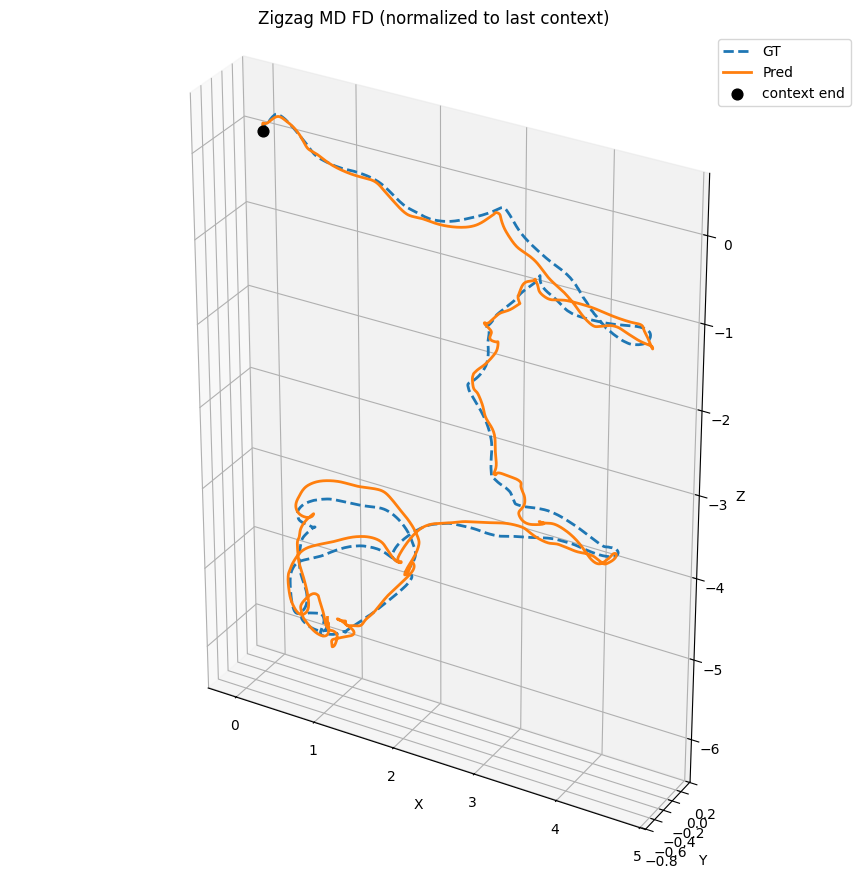

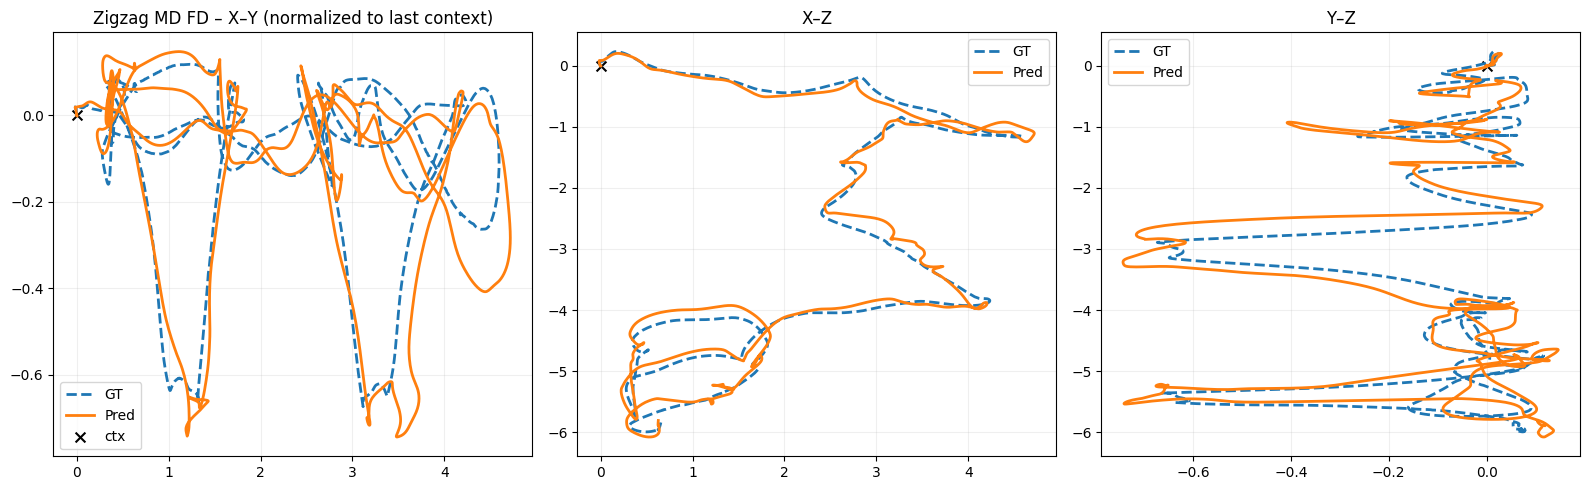

In [22]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D1_All_CSVs/cleaned_Take 072817_Sub1_NewZigZag1 12.26.30 PM edit.npy"
arr = np.load(file_path).astype(np.float32)
model, mu, sig = model_D, mu_D, sig_D
# model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Zigzag MD FD",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Zigzag MD FD", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))

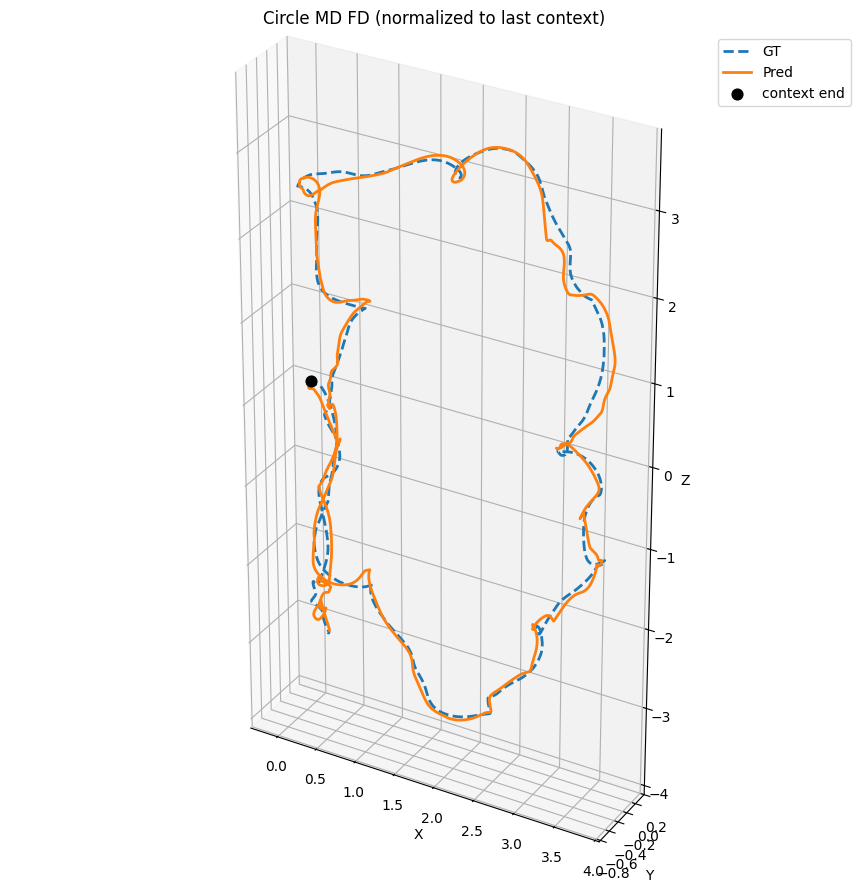

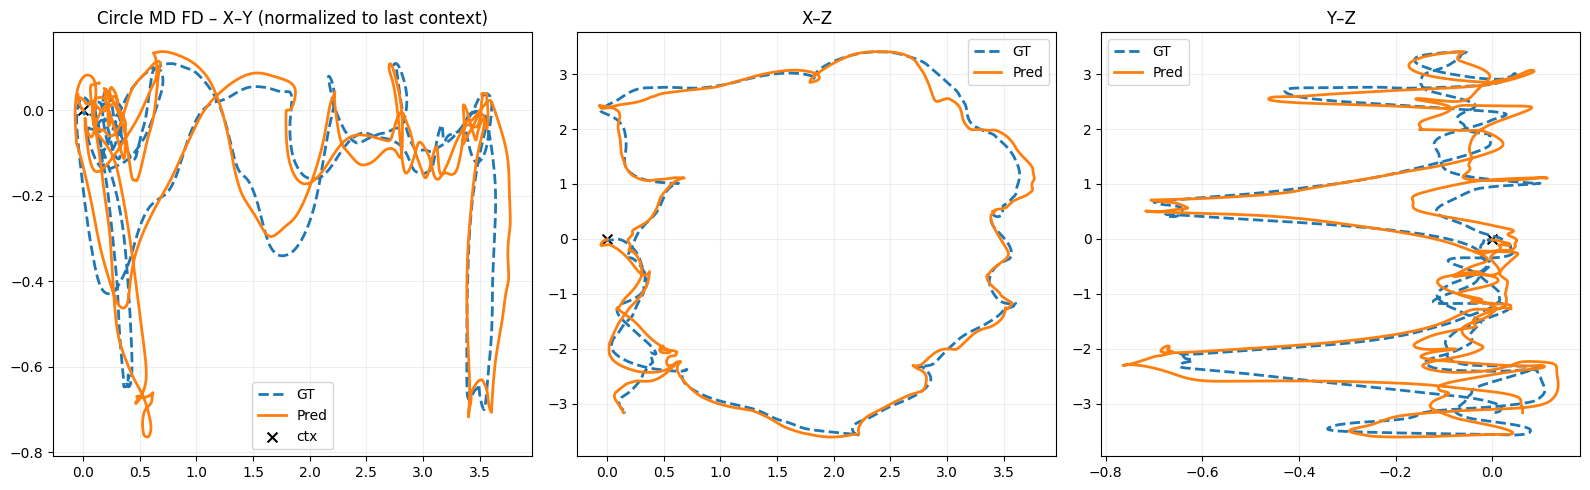

In [23]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D2_All_CSVs/cleaned_Take 080317_Sub2_Circle3 10.41.27 AM edit.npy"
arr = np.load(file_path).astype(np.float32)
model, mu, sig = model_D, mu_D, sig_D
# model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Circle MD FD",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Circle MD FD", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))

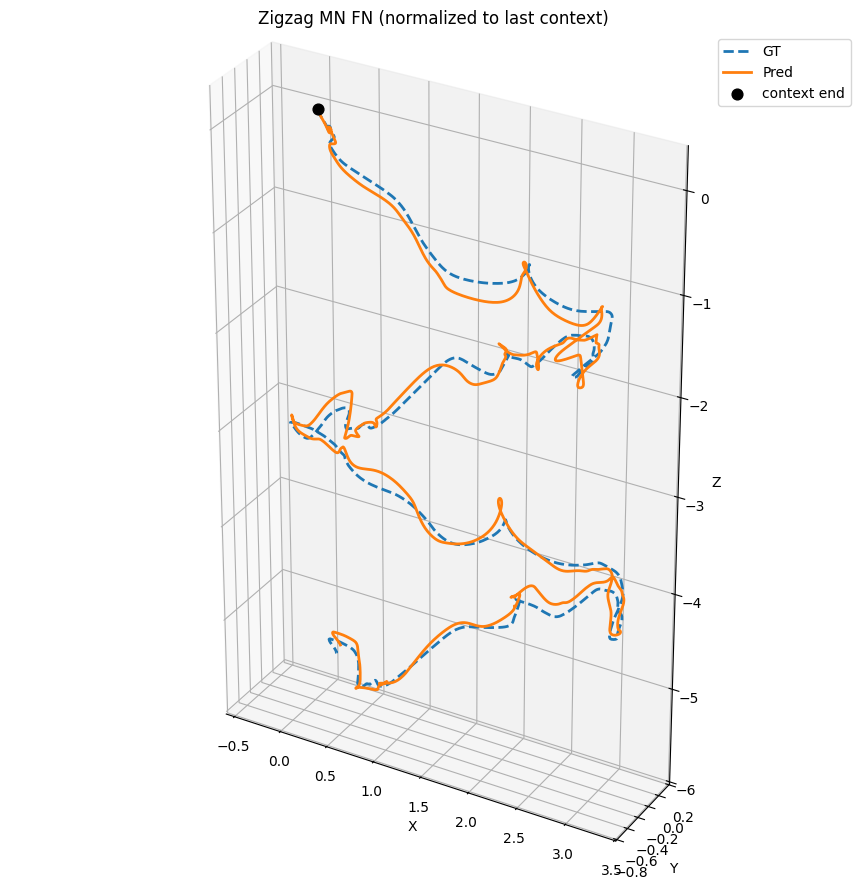

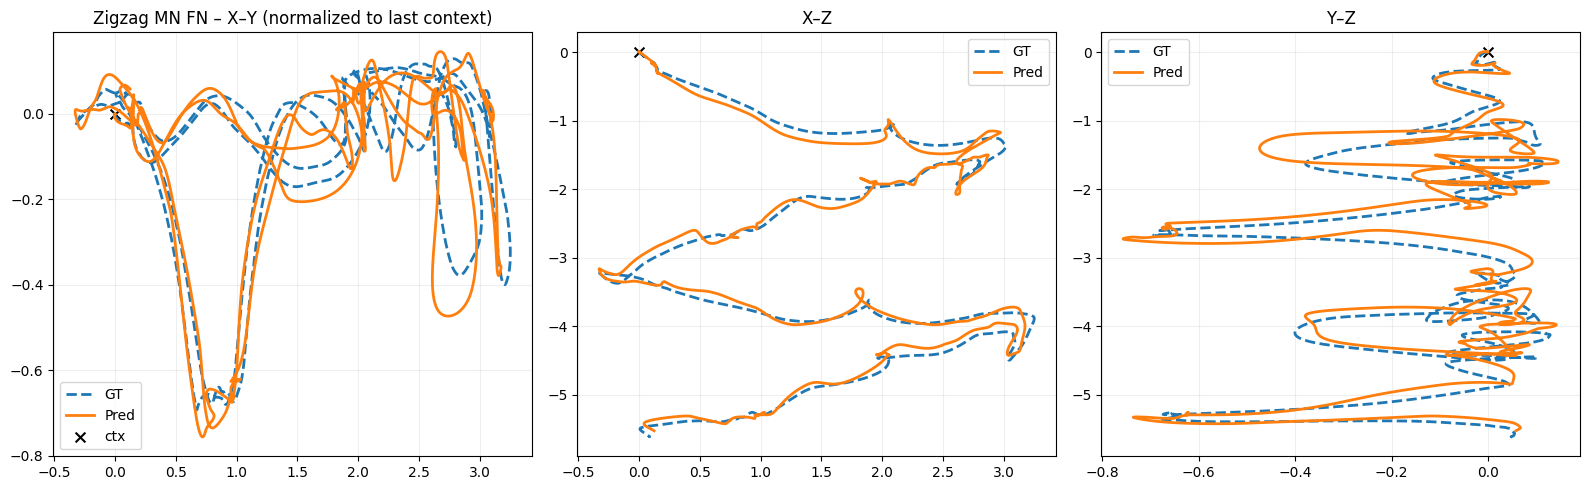

In [24]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D7_All_CSVs/cleaned_Take 091317_Sub8_NewZigZag2 01.10.40 PM edit.npy"
arr = np.load(file_path).astype(np.float32)
#model, mu, sig = model_D, mu_D, sig_D
model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Zigzag MN FN",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Zigzag MN FN", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))

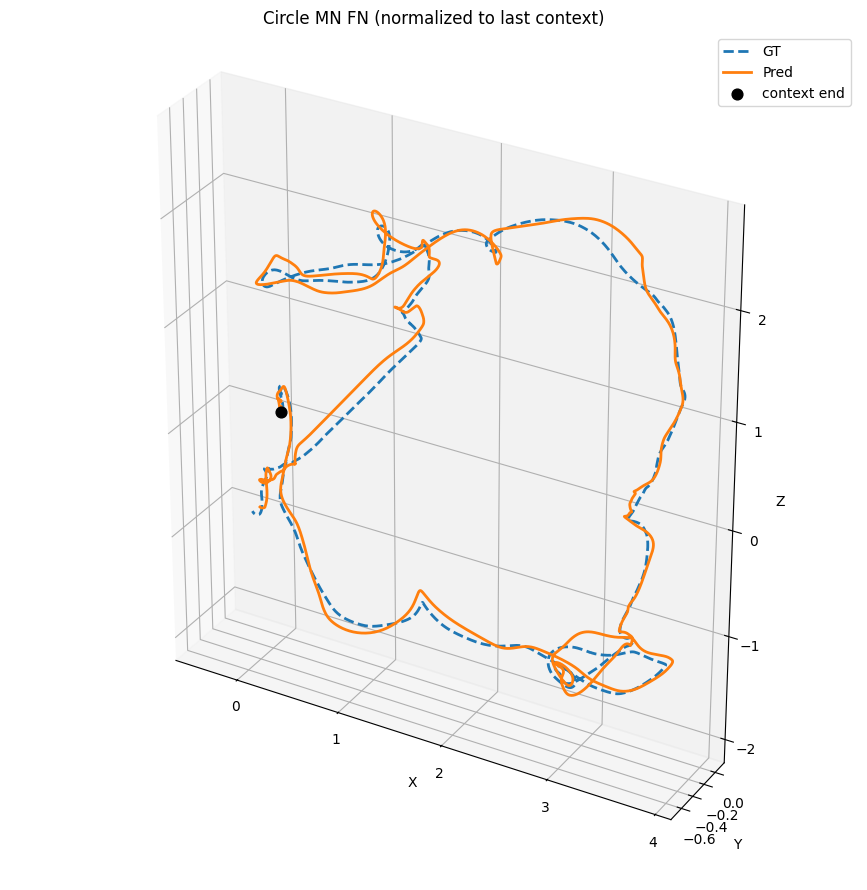

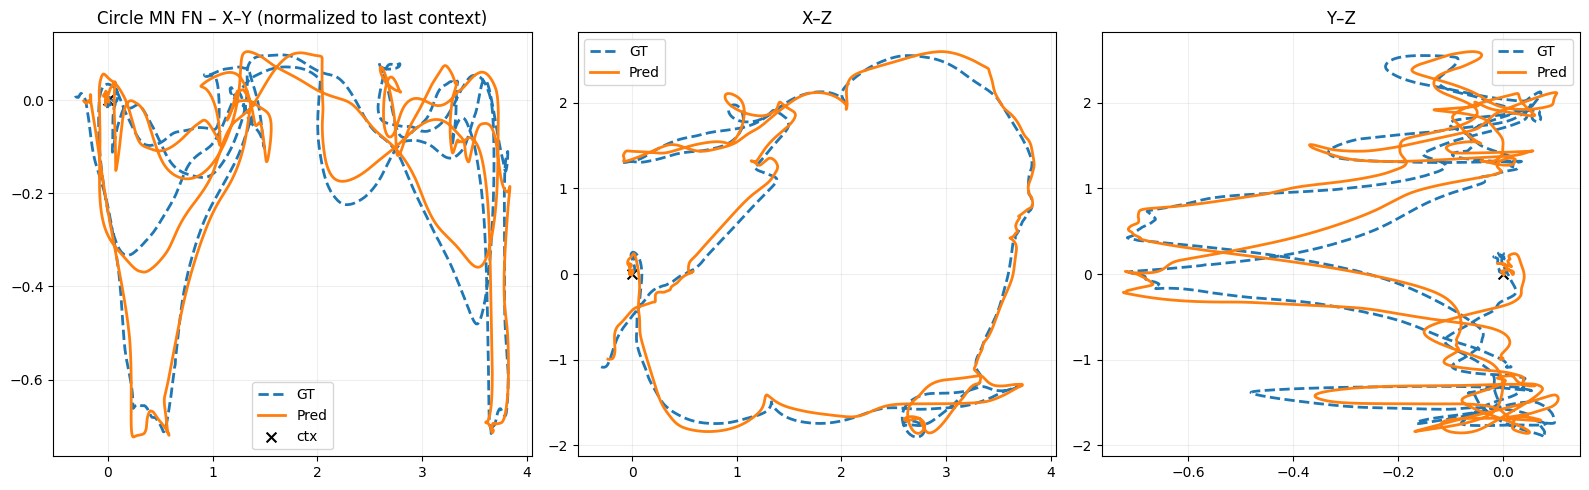

In [25]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D9_All_CSVs/cleaned_Take 091517_Sub10_Circle2 01.11.06 PM edit.npy"
arr = np.load(file_path).astype(np.float32)
#model, mu, sig = model_D, mu_D, sig_D
model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Circle MN FN",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Circle MN FN", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))

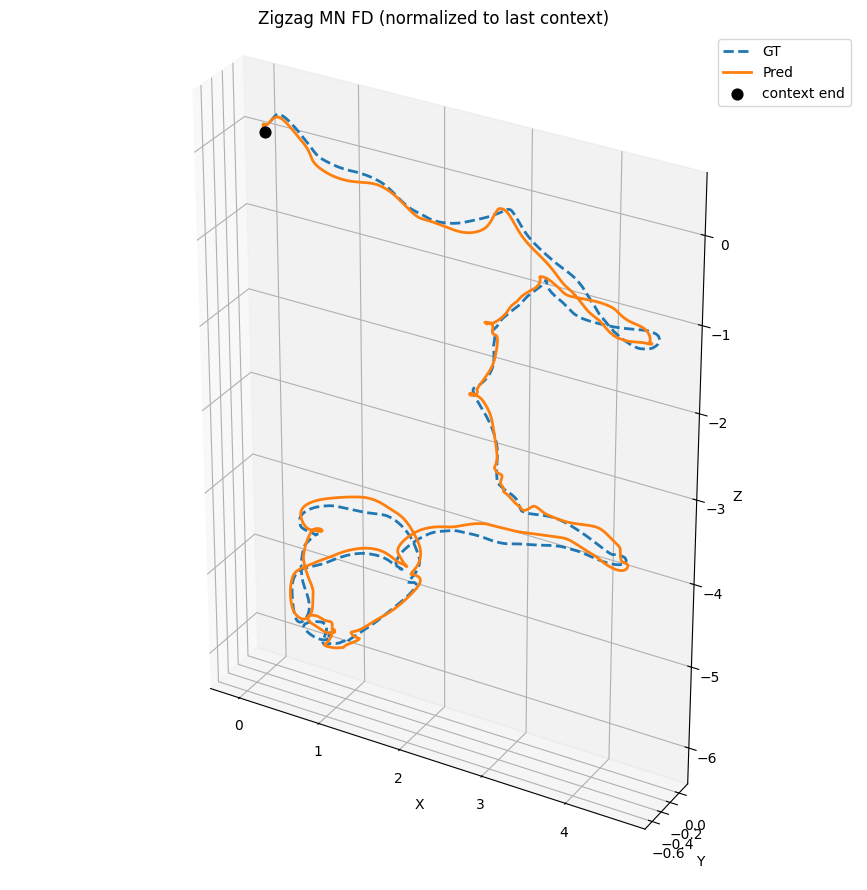

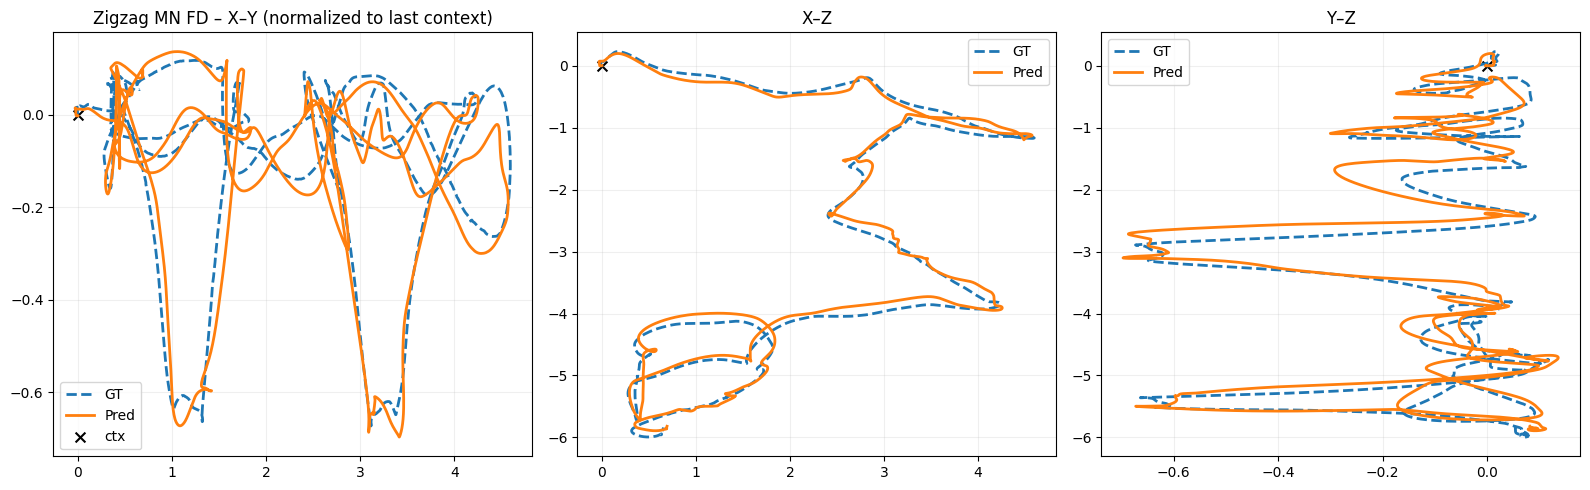

In [26]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D1_All_CSVs/cleaned_Take 072817_Sub1_NewZigZag1 12.26.30 PM edit.npy"
arr = np.load(file_path).astype(np.float32)
#model, mu, sig = model_D, mu_D, sig_D
model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Zigzag MN FD",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Zigzag MN FD", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))

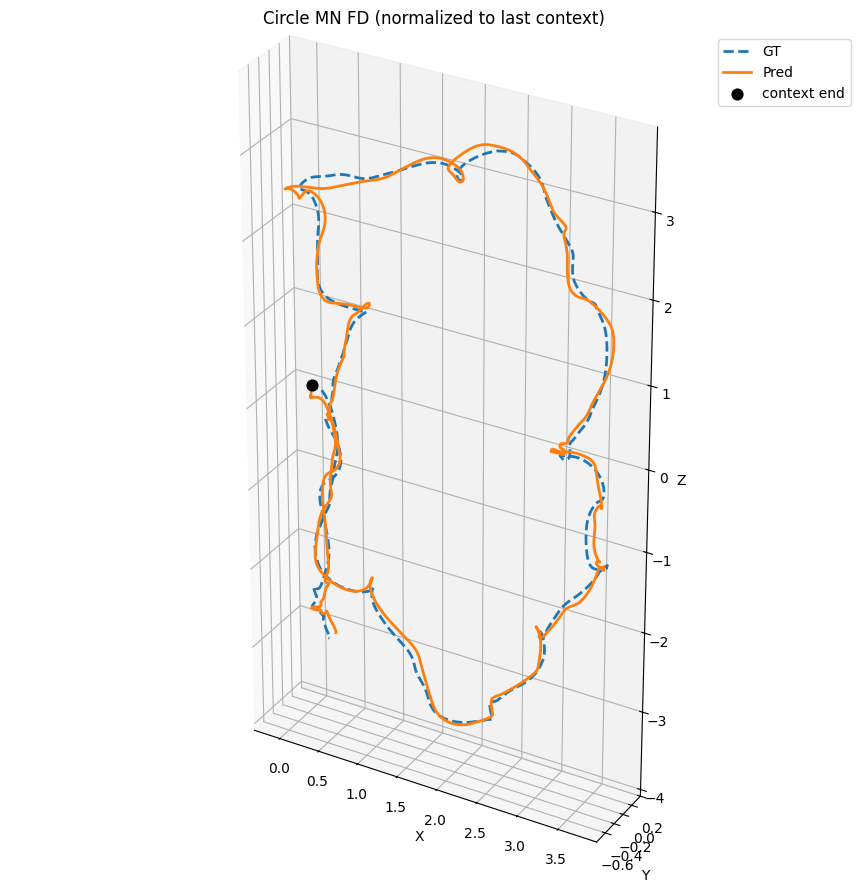

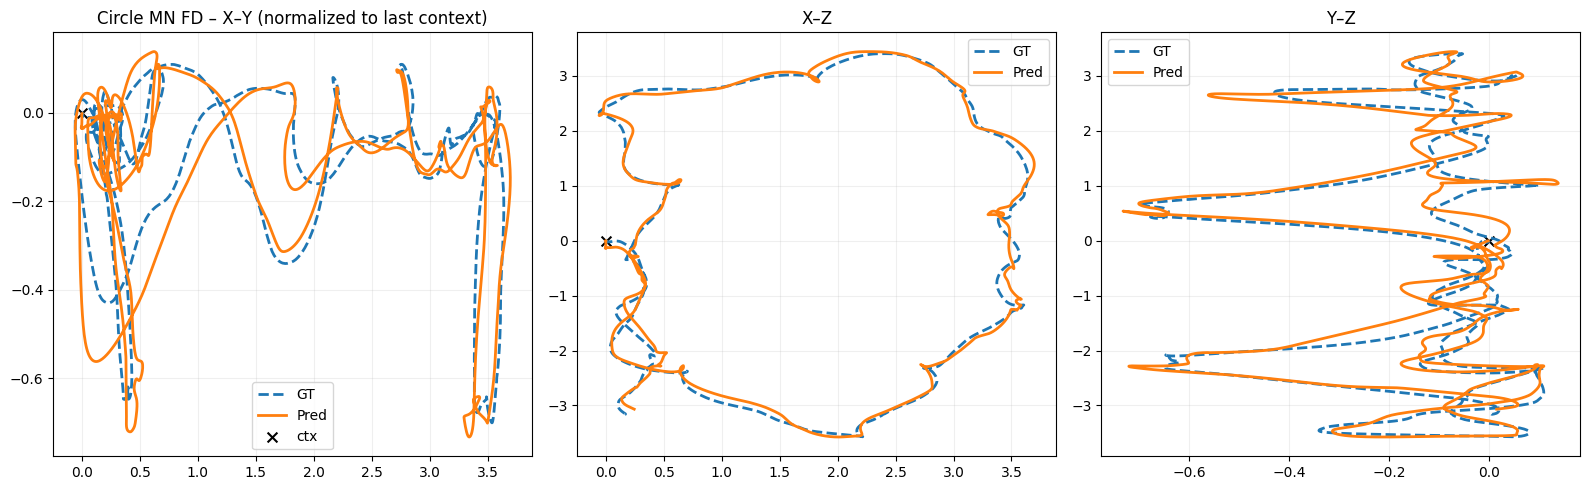

In [27]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D2_All_CSVs/cleaned_Take 080317_Sub2_Circle3 10.41.27 AM edit.npy"
arr = np.load(file_path).astype(np.float32)
#model, mu, sig = model_D, mu_D, sig_D
model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Circle MN FD",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Circle MN FD", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))

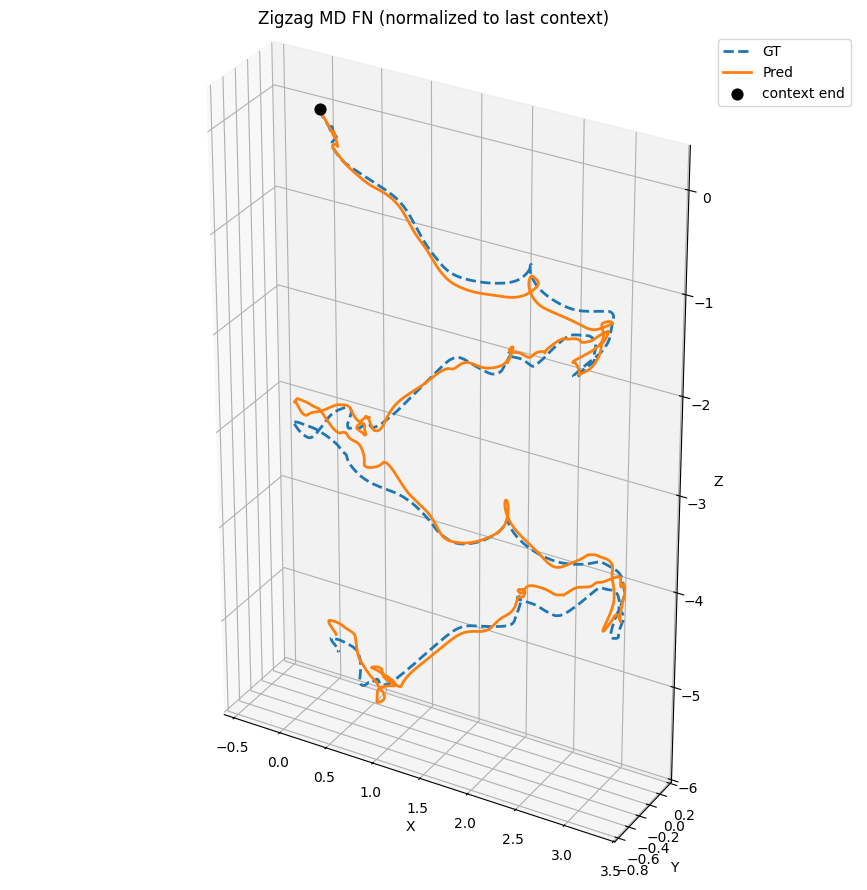

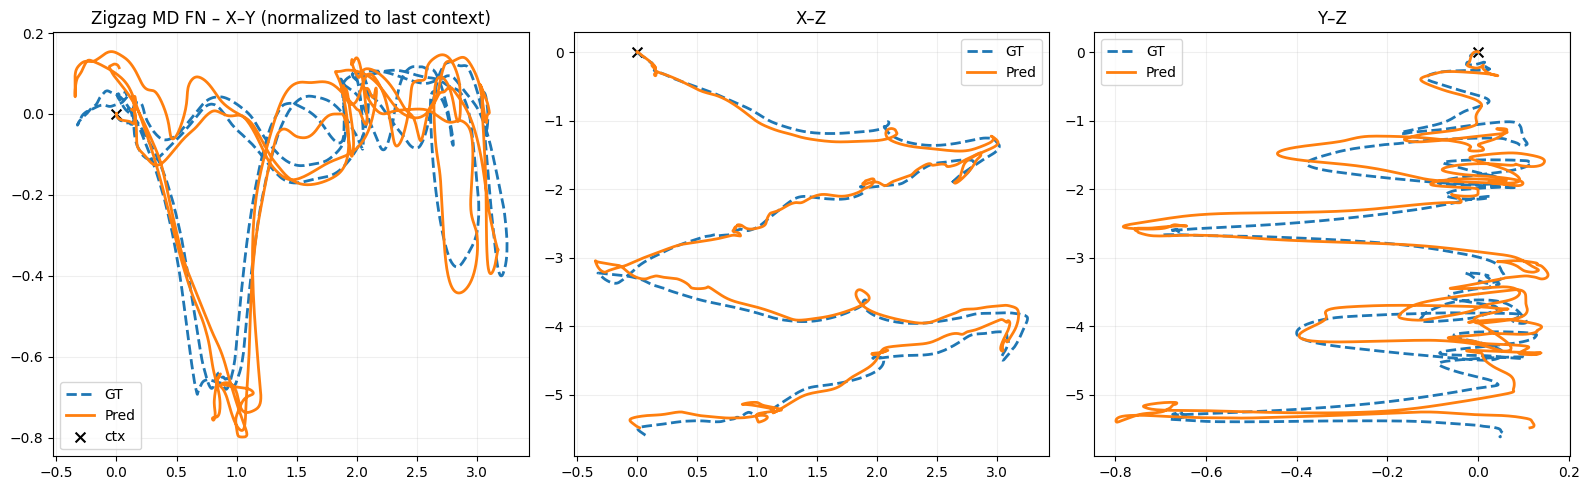

In [28]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D7_All_CSVs/cleaned_Take 091317_Sub8_NewZigZag2 01.10.40 PM edit.npy"
arr = np.load(file_path).astype(np.float32)
model, mu, sig = model_D, mu_D, sig_D
# model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Zigzag MD FN",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Zigzag MD FN", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))

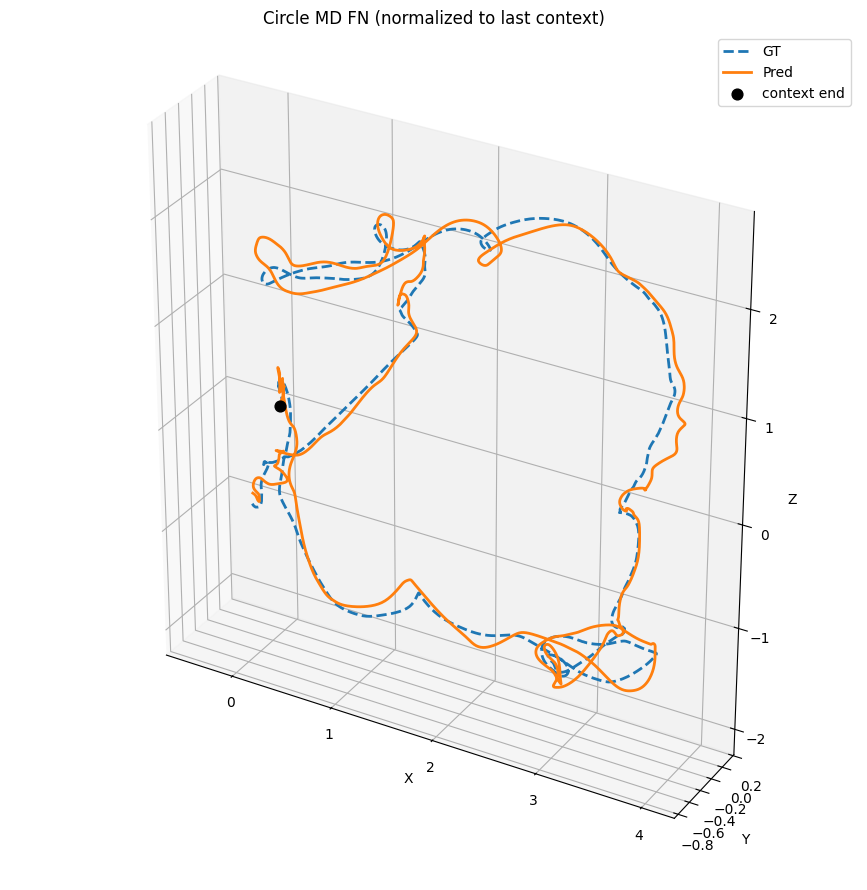

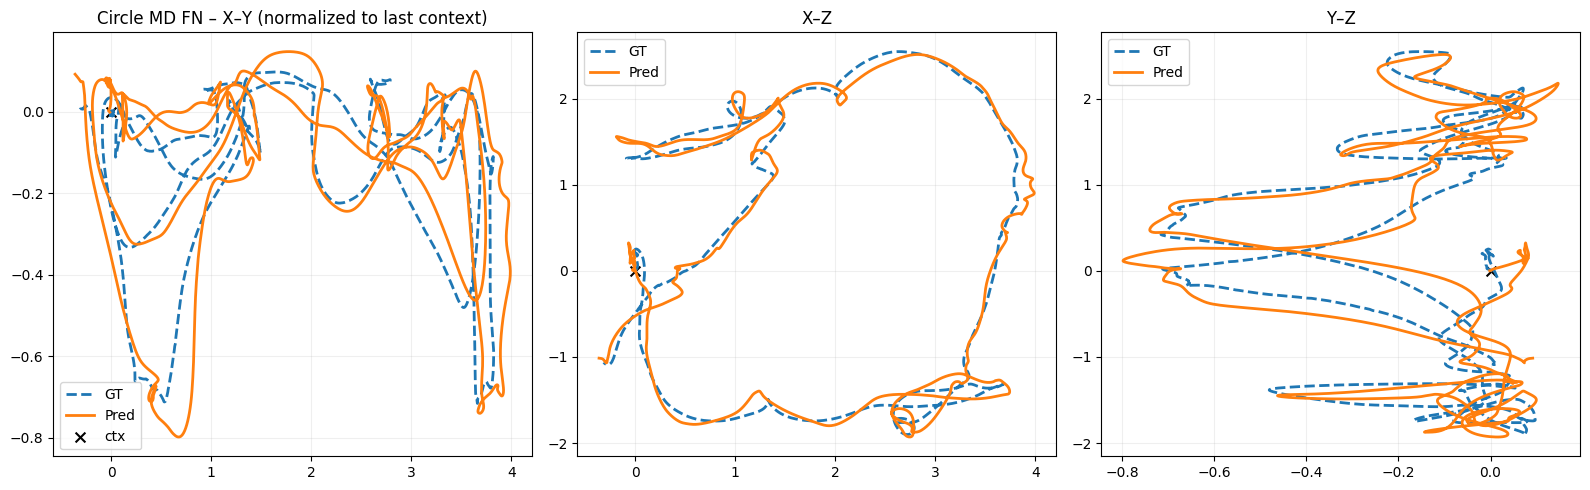

In [29]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D9_All_CSVs/cleaned_Take 091517_Sub10_Circle2 01.11.06 PM edit.npy"
arr = np.load(file_path).astype(np.float32)
model, mu, sig = model_D, mu_D, sig_D
# model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Circle MD FN",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Circle MD FN", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))

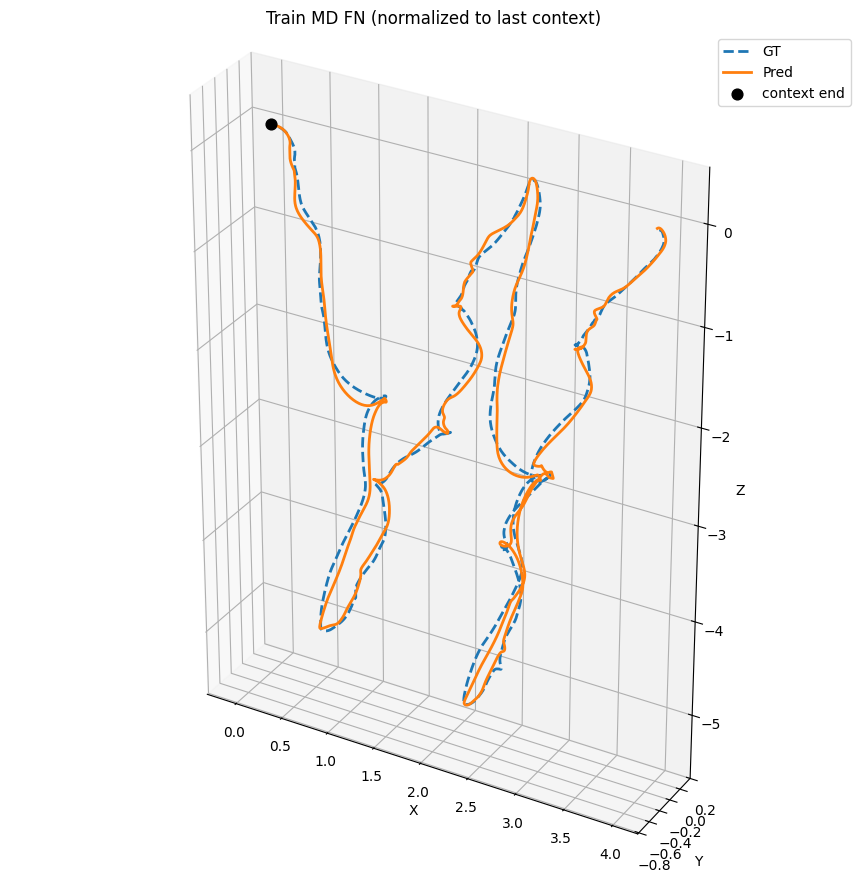

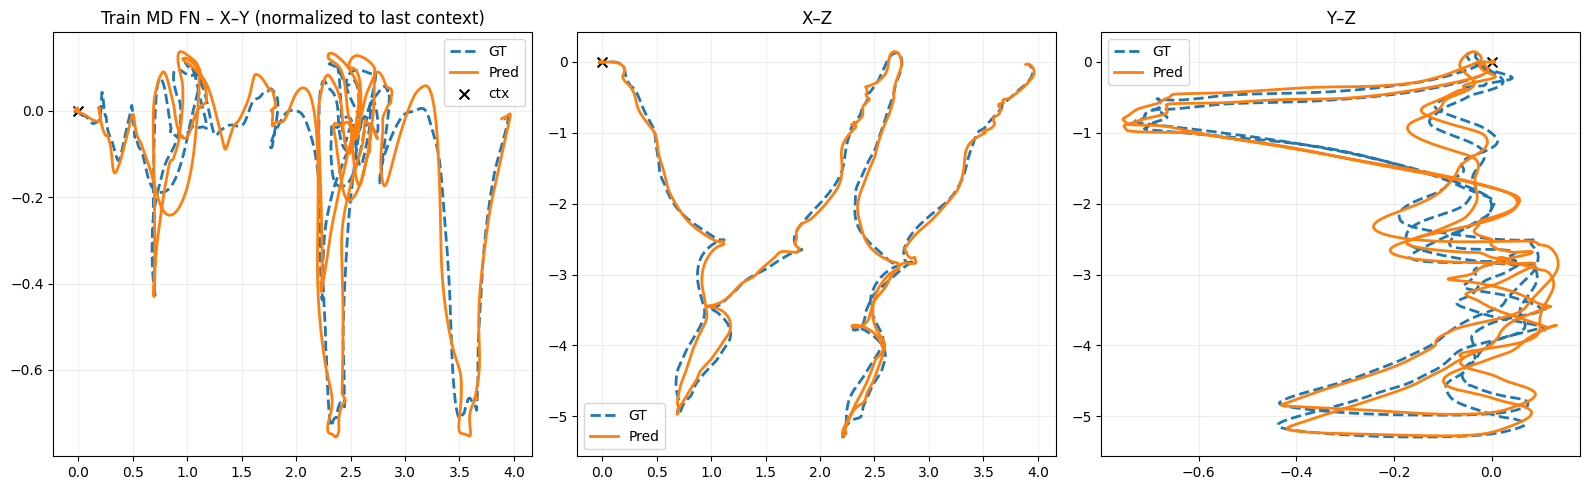

In [30]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D9_All_CSVs/cleaned_Take 091517_Sub10_train3 01.00.35 PM edit.npy"
arr = np.load(file_path).astype(np.float32)
model, mu, sig = model_D, mu_D, sig_D
# model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Train MD FN",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Train MD FN", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))

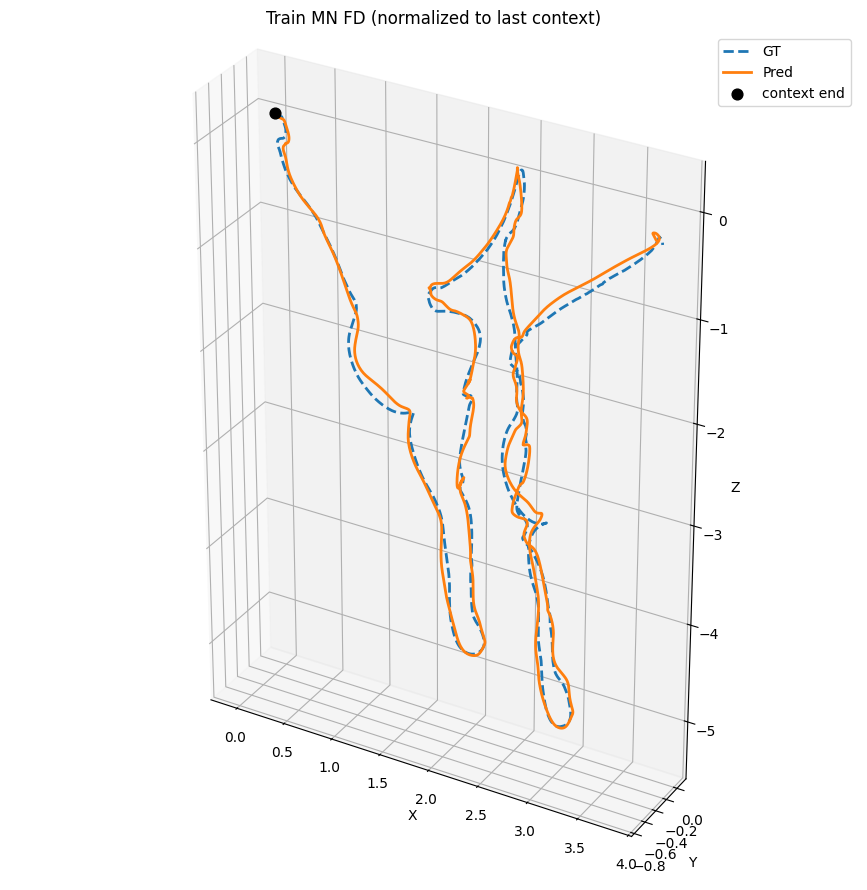

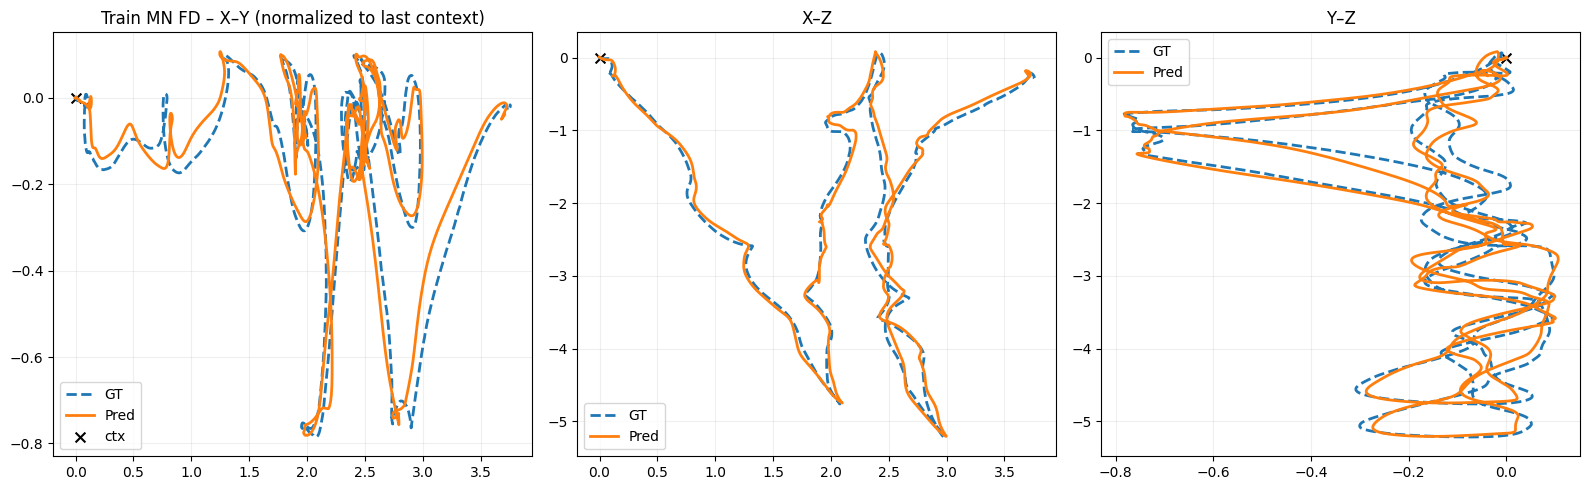

In [31]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D3_All_CSVs/cleaned_Take 090617_Sub4_train1 01.41.03 PM edit.npy"
arr = np.load(file_path).astype(np.float32)
#model, mu, sig = model_D, mu_D, sig_D
model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Train MN FD",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Train MN FD", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))